In [2]:
import numpy as np

diameter = 4000     # Durchmesser Gebiet

tmax = 50

a = 450             # Halber Abstand der Bohrungen
lc = diameter / 10  #



M = 30             # Mächtigkeit des Aquifers (m)
phi = 0.4          # Porosität des Aquifers
rho_S = 1900         # Dichte 
c_S = 850             # Wärmekapazität
lambda_S = 3.0      # Wärmeleitfähigkeit

# Fluid
rho_F = 1500
c_F = 4200

a2s = 365*24*3600   # Umrechnung von Sekunden in Jahre

rho_A_c_A = phi * rho_F * c_F + (1 - phi) * rho_S * c_S
L = np.sqrt(2*tmax*a2s*lambda_S/rho_A_c_A)

print(f"Der Einflussbereich im Aquitard beträgt {L:.2f}m")

Der Einflussbereich im Aquitard beträgt 52.07m


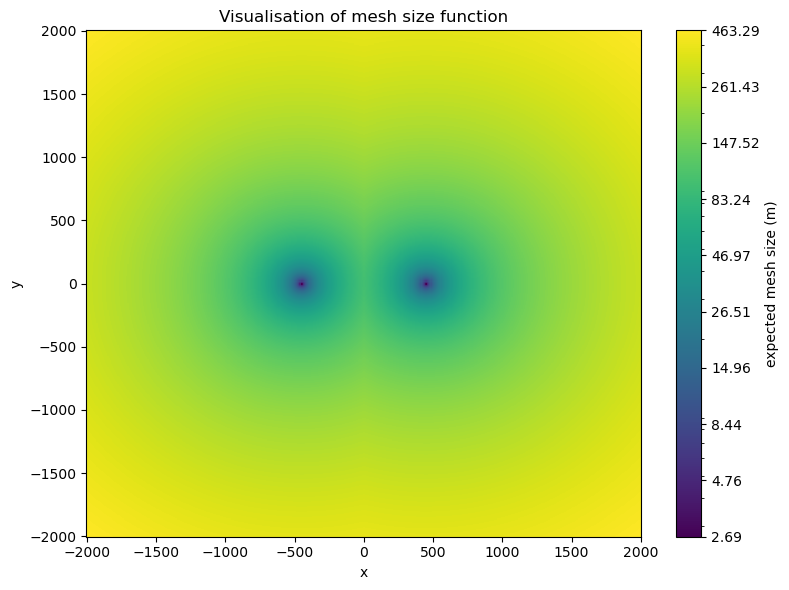

In [ ]:
#Install gmsh without X11 dependency
!pip install -i https://gmsh.info/python-packages-dev-nox --force-reinstall --no-cache-dir gmsh

import pygmsh
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def field(x, y, d):
    return 0.4*np.power(np.sqrt((x+d)*(x+d) + y*y), 0.9)+1.0

def doublet(x, y, d):
    return np.minimum(field(x, y, -d), field(x, y, d))

# Parameter
x_range = np.linspace(-diameter/2, diameter/2, 500)
y_range = np.linspace(-diameter/2, diameter/2, 500)
X, Y = np.meshgrid(x_range, y_range)

# Feld berechnen
Z = doublet(X, Y, d=a)

# Wertebereich festlegen
z_min = np.min(Z)
z_max = np.max(Z)

# Plot mit logarithmischer Farbskala
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, Z, shading='auto', norm=LogNorm(vmin=z_min, vmax=z_max), cmap='viridis')
cbar = plt.colorbar(label='expected mesh size (m)')
plt.title('Visualisation of mesh size function')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

ticks = np.geomspace(z_min, z_max, 10)  # Beispiel: min, mittel, max
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks])


plt.show()

C:\Tecklenburg.J\Anwendungsdaten\Python\Python311\site-packages\pygmsh\occ\geometry.py:253: UserWarning: Specified mesh size for <pygmsh Disk object, ID 1> discarded in Boolean fragments operation.
  warnings.warn(


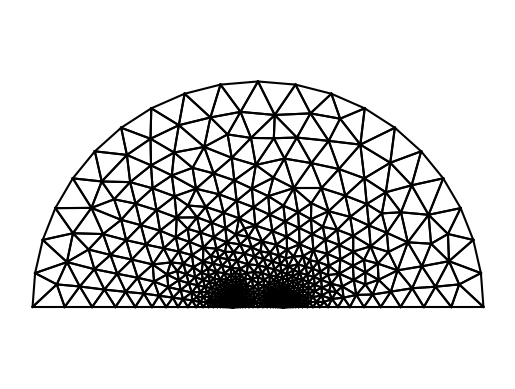

In [ ]:
with pygmsh.occ.Geometry() as geom:

    #Disk as base geometry
    disk = geom.add_disk([0.0, 0.0], diameter, mesh_size=lc)

    #Add injection and extraction well as points in the geometry
    for b in [-a, a]:
        p = geom.add_point([b, 0, 0], mesh_size=0.1)
        geom.boolean_fragments([disk], [p], delete_other=False)

    #
    rectangle = [geom.add_rectangle([-diameter, -diameter, 0.0], 2*diameter, diameter)]
    geom.boolean_difference(disk, rectangle)

    geom.set_mesh_size_callback(
        lambda dim, tag, x, y, z, lc: doublet(x,y,a)
    )

    mesh = geom.generate_mesh()

triangles = mesh.cells_dict["triangle"]
points = mesh.points

pts = points[:, :2]
for e in triangles:
    for idx in [[0, 1], [1, 2], [2, 0]]:
        X = pts[e[idx]]
        plt.plot(X[:, 0], X[:, 1], "-k")

plt.gca().set_aspect("equal", "datalim")
plt.axis("off")
plt.show()

mesh.write("domain.vtu")

In [ ]:
import pyvista as pv
from geo import layersfromsurf

nAquifer = 3
nAquitard = 5

phiAquitard = 0.1
KAquifer = 1e-10
KAquitard = 1e-14

for file in ["domain.vtu"]:

    mesh2d = pv.read(file)

    pAquitard = np.geomspace(0.1, L, nAquitard+2)
    dAquitard = np.diff(pAquitard)
    thickness = np.hstack((np.flip(dAquitard), np.array([M/2/nAquifer] * nAquifer)))

    mesh3d = layersfromsurf(mesh2d, thickness)

    mesh3d["Porosity"] = np.repeat(phi, mesh3d.number_of_cells)
    mesh3d["Porosity"][mesh3d["Layer"] < nAquitard] = phiAquitard
    mesh3d["Porosity"][mesh3d["Layer"] > (nAquitard+nAquifer)] = phiAquitard

    mesh3d["Permeability"] = np.repeat(phi, mesh3d.number_of_cells)
    mesh3d["Permeability"][mesh3d["Layer"] < nAquitard] = KAquifer 
    mesh3d["Permeability"][mesh3d["Layer"] > (nAquitard+nAquifer)] = KAquitard

    mesh3d.save(file)

#mesh3d.plot(scalars="Layer", show_edges=True, cmap="viridis")
mesh3d.plot(scalars="Porosity", show_edges=True, cmap="Pastel1")

Widget(value='<iframe src="http://localhost:52225/index.html?ui=P_0x214d067f210_0&reconnect=auto" class="pyvis…

In [ ]:
surf = mesh3d.extract_surface()
cell_normals = surf.cell_normals

n_vectors = [[0, 0, -1],[0,0,1],[0,1,0]]
surf_names = ["bottom", "top", "profile"]
unsurf_name = "boundary"
eps = 1e-8

all_selected = np.array([])

for n1, name in zip(n_vectors, surf_names):

    # L2-Norm berechnen (also die euklidische Norm)
    l2_norms = np.linalg.norm(cell_normals - n1, axis=1)  # shape: (n,)
    selected_cells = np.where(l2_norms < eps)[0]  # z.B. fast senkrecht nach oben
    subset = surf.extract_cells(selected_cells)
    subset.save(name + ".vtu")

    all_selected = np.concatenate((all_selected, selected_cells))

# Nicht ausgewählte Zellen
unselected_cells = np.setdiff1d(np.arange(surf.n_cells), all_selected)

un_subset = surf.extract_cells(unselected_cells)
un_subset.save(unsurf_name + ".vtu")

un_subset.plot()

Widget(value='<iframe src="http://localhost:52225/index.html?ui=P_0x214d2e560d0_1&reconnect=auto" class="pyvis…

In [ ]:
import pyvista as pv
import numpy as np

# 🔧 Eingabedatei und Zielpunkte
input_vtu = r"profile.vtu"  # Pfad zur bestehenden VTU-Datei
output_vtu = [r"injection.vtu", r"extraction.vtu"]  # Pfad zur neuen VTU-Datei

# Zwei bekannte Punkte (z. B. Start und Ende der Linie)
points = np.array([[[a, 0, -1000], [a, 0, 1000]], # Injection well
          [[-a, 0, -1000], [-a, 0, 1000]]]) # Extraction well

# 📥 VTU-Datei laden
mesh = pv.read(input_vtu)

# 🔍 Punkte entlang der Linie extrahieren
def finde_nahe_punkte(mesh, start, ende, tolerance=1e-3):
    # Richtung und Länge der Linie
    richtung = ende - start
    länge = np.linalg.norm(richtung)
    richtung_normiert = richtung / länge

    # Punkte im Mesh
    punkte = mesh.points
    extrahierte_ids = []

    for i, p in enumerate(punkte):
        v = p - start
        proj = np.dot(v, richtung_normiert)
        if 0 <= proj <= länge:
            dist = np.linalg.norm(v - proj * richtung_normiert)
            if dist < tolerance:
                extrahierte_ids.append(i)

    return extrahierte_ids

for p, out_vtu in zip(points, output_vtu):

    # 🧵 Punkte extrahieren
    ids = finde_nahe_punkte(mesh, p[0], p[1])

    # Neue Punktwolke erstellen
    extrahierte_punkte = mesh.points[ids]

    # 🔁 Linie als UnstructuredGrid aufbauen
    n = len(extrahierte_punkte) - 1
    cells = []
    cell_types = []

    for i in range(n):
        cells.extend([2, i, i+1])  # Jede Linie besteht aus 2 Punkten
        cell_types.append(pv.CellType.LINE)

    # UnstructuredGrid erzeugen
    linie_mesh = pv.UnstructuredGrid(np.array(cells), cell_types, extrahierte_punkte)

    # 💾 Als VTU speichern
    linie_mesh.save(out_vtu)
    print(f"Linie gespeichert als: {out_vtu}")


# Plotter erstellen
plotter = pv.Plotter()
plotter.add_mesh(linie_mesh, color="red", line_width=4)
plotter.add_points(linie_mesh.points, color="blue", point_size=15, render_points_as_spheres=True)
plotter.show_axes()
plotter.show()


Linie gespeichert als: injection.vtu
Linie gespeichert als: extraction.vtu


Widget(value='<iframe src="http://localhost:52225/index.html?ui=P_0x214d2ec6b90_3&reconnect=auto" class="pyvis…

In [ ]:
import ogstools as ogs

# Simulate problem with TwoPhaseFlowPP and TH2M
prj_file = r"doublet.prj"

prj = ogs.Project(input_file=prj_file, output_file=prj_file)
#prj.write_input()        
prj.run_model()